In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.optimize import minimize


In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
print("Seed:", SEED)


device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Seed: 42
Device: cpu


# Section 1

In [3]:
# Ill-conditioned Hessian
H = np.array([[1.0, 0.0],
              [0.0, 50.0]])

# quadratic function: J(v) = 0.5 v^T H v
def cost_func(v):
    return 0.5 * v.T @ H @ v

# gradient \nabla J = H v
def grad(v):
    return H @ v

In [4]:
def gradient_descent(theta0, alpha=0.1, iters=50):
    theta = theta0.copy()
    traj = [theta.copy()]
    for _ in range(iters):
        g = grad(theta)
        theta = theta - alpha * g
        traj.append(theta.copy())
    return np.array(traj)

In [5]:
H_inv = np.linalg.inv(H)

def newton_method(theta0, iters=5):
    theta = theta0.copy()
    traj = [theta.copy()]
    for _ in range(iters):
        g = grad(theta)
        theta = theta - H_inv @ g
        traj.append(theta.copy())
    return np.array(traj)

In [6]:
def conjugate_gradient(theta0, iters=10):
    theta = theta0.copy()
    traj = [theta.copy()]

    r = -grad(theta)       # residual = -gradient
    p = r.copy()           # initial direction

    for _ in range(iters):
        Ap = H @ p
        alpha = (r.T @ r) / (p.T @ Ap)

        theta = theta + alpha * p
        traj.append(theta.copy())

        r_new = r - alpha * Ap
        if np.linalg.norm(r_new) < 1e-10:
            break

        beta = (r_new.T @ r_new) / (r.T @ r)
        p = r_new + beta * p
        r = r_new

    return np.array(traj)


In [7]:
theta0 = np.array([5.0, 5.0])

gd_traj = gradient_descent(theta0, alpha=0.1, iters=100)
newton_traj = newton_method(theta0, iters=3)
cg_traj = conjugate_gradient(theta0, iters=5)

print("GD final:", gd_traj[-1])
print("Newton final:", newton_traj[-1])
print("CG final:", cg_traj[-1])


GD final: [1.32806994e-04 8.03469022e+60]
Newton final: [0. 0.]
CG final: [0.00000000e+00 1.46050706e-14]


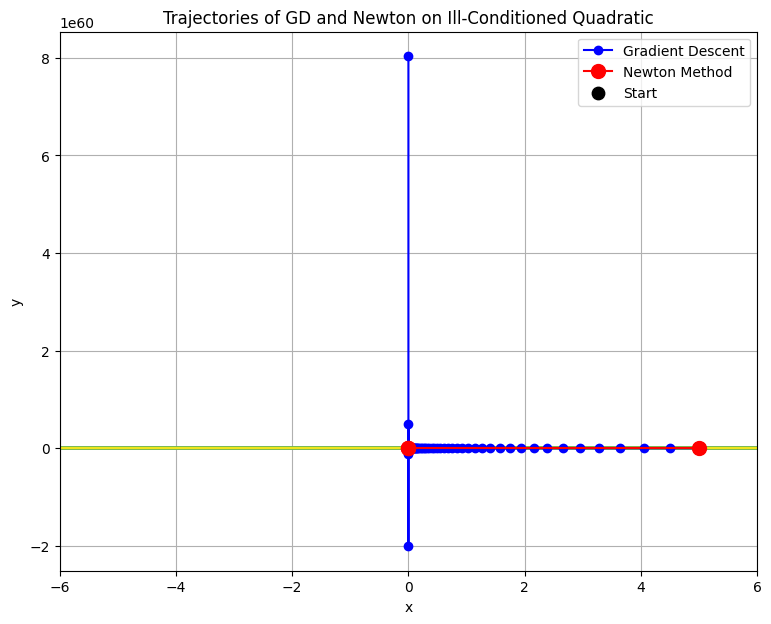

In [8]:
x = np.linspace(-6, 6, 400)
y = np.linspace(-6, 6, 400)
X, Y = np.meshgrid(x, y)

Z = 0.5 * (X**2 + 50*(Y**2))

plt.figure(figsize=(9,7))
plt.contour(X, Y, Z, levels=40, cmap='viridis')

plt.plot(gd_traj[:,0], gd_traj[:,1], 'o-', color='blue', label='Gradient Descent')

plt.plot(newton_traj[:,0], newton_traj[:,1], 'o-', color='red', label='Newton Method', markersize=10)

plt.scatter([theta0[0]], [theta0[1]], color='black', s=80, label='Start')

plt.title("Trajectories of GD and Newton on Ill-Conditioned Quadratic")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


## More in-depth for Section 1

Method comparison on quadratics    Condition_k  lambda_min  lambda_max  cond_number  GD_iters  GD_time_s  \
0           10         1.0        10.0         10.0       312   0.016715   
1           50         1.0        50.0         50.0      1611   0.034502   
2          200         1.0       200.0        200.0      5000   0.202589   
3          500         1.0       500.0        500.0      5000   0.142894   

   GD_final_loss  Newton_iters  Newton_time_s  Newton_final_loss  CG_iters  \
0   3.457314e-25             2       0.000070                0.0         2   
1   4.787664e-25             2       0.000069                0.0         2   
2   3.232612e-19             2       0.000102                0.0         3   
3   1.873119e-07             2       0.000101                0.0         3   

   CG_time_s  CG_final_loss  
0   0.000089   5.456015e-30  
1   0.000091   5.332702e-27  
2   0.000105   6.900030e-27  
3   0.000101   1.334323e-24  


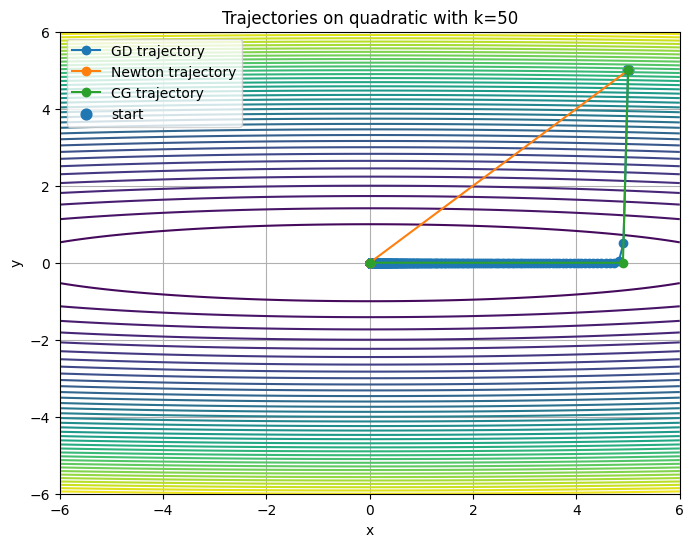

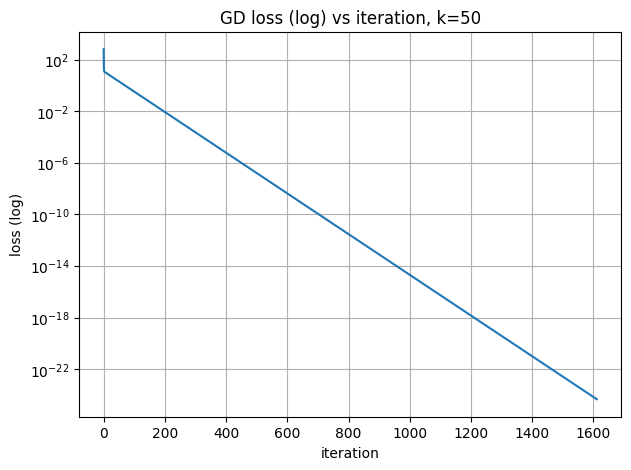

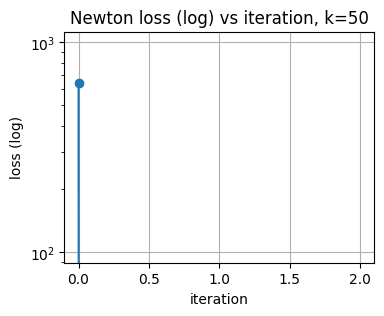

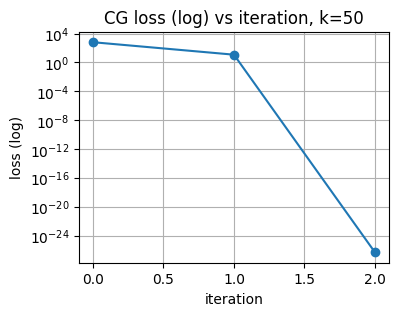

In [9]:
def cost(v, H):
    return 0.5 * v.T @ H @ v

def grad(v, H):
    return H @ v

def gradient_descent(theta0, H, alpha, iters=2000, tol=1e-10):
    theta = theta0.copy()
    traj = [theta.copy()]
    losses = [cost(theta, H)]
    start = time.perf_counter()
    for i in range(iters):
        g = grad(theta, H)
        theta = theta - alpha * g
        traj.append(theta.copy())
        losses.append(cost(theta, H))
        if np.linalg.norm(g) < tol:
            break
    wall = time.perf_counter() - start
    return np.array(traj), np.array(losses), wall, i+1

def newton_method(theta0, H, iters=10, tol=1e-12):
    H_inv = np.linalg.inv(H)
    theta = theta0.copy()
    traj = [theta.copy()]
    losses = [cost(theta, H)]
    start = time.perf_counter()
    for i in range(iters):
        g = grad(theta, H)
        theta = theta - H_inv @ g
        traj.append(theta.copy())
        losses.append(cost(theta, H))
        if np.linalg.norm(g) < tol:
            break
    wall = time.perf_counter() - start
    return np.array(traj), np.array(losses), wall, i+1

def conjugate_gradient(theta0, H, iters=10, tol=1e-12):
    theta = theta0.copy()
    traj = [theta.copy()]
    losses = [cost(theta, H)]
    r = -grad(theta, H)  # residual = -gradient for min 0.5 x^T H x
    p = r.copy()
    start = time.perf_counter()
    for i in range(iters):
        Ap = H @ p
        denom = (p.T @ Ap)
        if abs(denom) < 1e-18:
            break
        alpha = (r.T @ r) / denom
        theta = theta + alpha * p
        traj.append(theta.copy())
        losses.append(cost(theta, H))
        r_new = r - alpha * Ap
        if np.linalg.norm(r_new) < tol:
            r = r_new
            break
        beta = (r_new.T @ r_new) / (r.T @ r)
        p = r_new + beta * p
        r = r_new
    wall = time.perf_counter() - start
    return np.array(traj), np.array(losses), wall, i+1

condition_numbers = [10, 50, 200, 500]  # different ill-conditioning levels
results = []

# initial point
theta0 = np.array([5.0, 5.0])

for k in condition_numbers:
    H = np.array([[1.0, 0.0],[0.0, float(k)]])
    eigvals = np.linalg.eigvalsh(H)
    cond = eigvals.max() / eigvals.min()

    lam_max = eigvals.max()
    alpha = 0.9 / lam_max

    gd_traj, gd_losses, gd_time, gd_iters = gradient_descent(theta0, H, alpha, iters=5000, tol=1e-12)
    new_traj, new_losses, new_time, new_iters = newton_method(theta0, H, iters=5, tol=1e-12)
    cg_traj, cg_losses, cg_time, cg_iters = conjugate_gradient(theta0, H, iters=5, tol=1e-12)

    results.append({
        "k": k,
        "eigvals": eigvals,
        "cond": cond,
        "alpha": alpha,
        "gd_iters": gd_iters,
        "gd_time": gd_time,
        "gd_final_loss": float(gd_losses[-1]),
        "new_iters": new_iters,
        "new_time": new_time,
        "new_final_loss": float(new_losses[-1]),
        "cg_iters": cg_iters,
        "cg_time": cg_time,
        "cg_final_loss": float(cg_losses[-1]),
        "gd_losses": gd_losses,
        "new_losses": new_losses,
        "cg_losses": cg_losses,
        "gd_traj": gd_traj,
        "new_traj": new_traj,
        "cg_traj": cg_traj
    })

df_rows = []
for r in results:
    df_rows.append({
        "Condition_k": r["k"],
        "lambda_min": r["eigvals"][0],
        "lambda_max": r["eigvals"][1],
        "cond_number": r["cond"],
        "GD_iters": r["gd_iters"],
        "GD_time_s": r["gd_time"],
        "GD_final_loss": r["gd_final_loss"],
        "Newton_iters": r["new_iters"],
        "Newton_time_s": r["new_time"],
        "Newton_final_loss": r["new_final_loss"],
        "CG_iters": r["cg_iters"],
        "CG_time_s": r["cg_time"],
        "CG_final_loss": r["cg_final_loss"],
    })
df = pd.DataFrame(df_rows)


print("Method comparison on quadratics", df)

k_show = 50
r = next(x for x in results if x["k"]==k_show)
gd_traj = r["gd_traj"]
new_traj = r["new_traj"]
cg_traj = r["cg_traj"]

x = np.linspace(-6, 6, 400)
y = np.linspace(-6, 6, 400)
X, Y = np.meshgrid(x, y)
Z = 0.5*(X**2 + k_show*(Y**2))

plt.figure(figsize=(8,6))
plt.contour(X, Y, Z, levels=40)
plt.plot(gd_traj[:,0], gd_traj[:,1], 'o-', label='GD trajectory')
plt.plot(new_traj[:,0], new_traj[:,1], 'o-', label='Newton trajectory')
plt.plot(cg_traj[:,0], cg_traj[:,1], 'o-', label='CG trajectory')
plt.scatter([theta0[0]], [theta0[1]], label='start', s=60)
plt.legend()
plt.title(f"Trajectories on quadratic with k={k_show}")
plt.xlabel("x"); plt.ylabel("y")
plt.grid(True)
plt.show()

# GD loss
plt.figure(figsize=(7,5))
plt.plot(r["gd_losses"])
plt.yscale('log')
plt.title(f"GD loss (log) vs iteration, k={k_show}")
plt.xlabel("iteration"); plt.ylabel("loss (log)")
plt.grid(True)
plt.show()

# Newton loss
plt.figure(figsize=(4,3))
plt.plot(r["new_losses"], marker='o')
plt.yscale('log')
plt.title(f"Newton loss (log) vs iteration, k={k_show}")
plt.xlabel("iteration"); plt.ylabel("loss (log)")
plt.grid(True)
plt.show()

# CG loss
plt.figure(figsize=(4,3))
plt.plot(r["cg_losses"], marker='o')
plt.yscale('log')
plt.title(f"CG loss (log) vs iteration, k={k_show}")
plt.xlabel("iteration"); plt.ylabel("loss (log)")
plt.grid(True)
plt.show()


In [10]:
# QR decorrelation effect on condition number

n_samples = 1000

x1 = np.random.randn(n_samples)
x2 = 0.95 * x1 + 0.1 * np.random.randn(n_samples)
X = np.vstack([x1, x2]).T  # shape (n_samples, 2)

cov = np.cov(X, rowvar=False)
eig_cov = np.linalg.eigvalsh(cov)
cond_cov = eig_cov.max() / eig_cov.min()

Q, R = np.linalg.qr(X)
cov_Q = np.cov(Q, rowvar=False)
eig_cov_Q = np.linalg.eigvalsh(cov_Q)
cond_cov_Q = eig_cov_Q.max() / eig_cov_Q.min()

qr_summary = pd.DataFrame({
    "matrix": ["X (features)", "Q (QR orthonormal columns)"],
    "lambda_min": [eig_cov[0], eig_cov_Q[0]],
    "lambda_max": [eig_cov[1], eig_cov_Q[1]],
    "cond_number": [cond_cov, cond_cov_Q]
})
print("QR decorrelation summary", qr_summary)

QR decorrelation summary                        matrix  lambda_min  lambda_max  cond_number
0                X (features)    0.005229    1.821461   348.342388
1  Q (QR orthonormal columns)    0.000995    0.001001     1.005561


# Section 2

In [11]:
data = load_breast_cancer()
X = data.data
y = data.target.reshape(-1, 1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

input_dim = X.shape[1]      # 30
hidden_dim = 5
output_dim = 1

In [12]:
# Total params = 30*5 + 5 + 5*1 + 1 = 151 parameters  (<500 OK)

class SmallNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.act = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.act(self.fc1(x))
        return self.sig(self.fc2(x))

model_sgd = SmallNet()
model_lbfgs = SmallNet()
model_cg = SmallNet()

loss_fn = nn.BCELoss()

In [13]:
#@title SGD
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.05)

losses_sgd = []
times_sgd  = []

start = time.time()
for epoch in range(200):
    optimizer_sgd.zero_grad()

    pred = model_sgd(X_train_t)
    loss = loss_fn(pred, y_train_t)

    loss.backward()
    optimizer_sgd.step()

    losses_sgd.append(loss.item())
    times_sgd.append(time.time() - start)

In [14]:
#@title L-BFGS
optimizer_lbfgs = optim.LBFGS(model_lbfgs.parameters(), lr=1.0, max_iter=20)

losses_lbfgs = []
times_lbfgs  = []

start = time.time()

def closure():
    optimizer_lbfgs.zero_grad()
    pred = model_lbfgs(X_train_t)
    loss = loss_fn(pred, y_train_t)
    loss.backward()
    return loss

for i in range(40):     # few iterations but heavy
    loss = optimizer_lbfgs.step(closure)
    losses_lbfgs.append(loss.item())
    times_lbfgs.append(time.time() - start)

In [15]:
#@title CG
def get_params_vector(model):
    return torch.cat([p.data.flatten() for p in model.parameters()]).numpy()

def set_params_vector(model, vector):
    idx = 0
    for p in model.parameters():
        size = p.numel()
        block = vector[idx:idx+size]
        p.data = torch.tensor(block.reshape(p.shape), dtype=torch.float32)
        idx += size

def f_loss(vec):
    set_params_vector(model_cg, vec)
    pred = model_cg(X_train_t)
    loss = loss_fn(pred, y_train_t)
    return float(loss.detach().numpy())

def f_grad(vec):
    set_params_vector(model_cg, vec)
    pred = model_cg(X_train_t)
    loss = loss_fn(pred, y_train_t)
    loss.backward()

    grad_list = []
    for p in model_cg.parameters():
        grad_list.append(p.grad.flatten())
    g = torch.cat(grad_list).detach().numpy()
    model_cg.zero_grad()
    return g

losses_cg = []
times_cg  = []

start = time.time()

def callback(v):
    losses_cg.append(f_loss(v))
    times_cg.append(time.time() - start)

init_vec = get_params_vector(model_cg)
res = minimize(
    fun=f_loss, x0=init_vec, jac=f_grad, method='CG', callback=callback,
    options={'maxiter': 50}
)


/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:108: RuntimeWarning: overflow encountered in cast
  return um.clip(a, min, max, out=out, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/optimize/_dcsrch.py:385: RuntimeWarning: overflow encountered in cast
  if stp == self.stpmax and f <= ftest and g <= self.gtest:
/usr/local/lib/python3.12/dist-packages/scipy/optimize/_dcsrch.py:469: RuntimeWarning: overflow encountered in cast
  if abs(self.sty - self.stx) >= p66 * self.width1:
/usr/local/lib/python3.12/dist-packages/scipy/optimize/_dcsrch.py:324: RuntimeWarning: overflow encountered in cast
  if stp > self.stpmax:


In [16]:
print(f'times sgd:\n {times_sgd}')
print(f'times lbfgs:\n {times_lbfgs}')
print(f'times cg:\n {times_cg}')

times sgd:
 [0.17428135871887207, 0.18035221099853516, 0.18665742874145508, 0.1944575309753418, 0.2023792266845703, 0.21025395393371582, 0.21810293197631836, 0.22600054740905762, 0.2336106300354004, 0.23507905006408691, 0.24286484718322754, 0.25075745582580566, 0.2585263252258301, 0.2651822566986084, 0.27074360847473145, 0.27637600898742676, 0.27812767028808594, 0.2873096466064453, 0.2942686080932617, 0.30002856254577637, 0.30580854415893555, 0.3135995864868164, 0.31511807441711426, 0.3209853172302246, 0.32549333572387695, 0.32895612716674805, 0.33145737648010254, 0.33269548416137695, 0.3371255397796631, 0.33983731269836426, 0.34313297271728516, 0.34647107124328613, 0.3477797508239746, 0.3489077091217041, 0.35237979888916016, 0.3558485507965088, 0.3571915626525879, 0.35813450813293457, 0.3591189384460449, 0.3686802387237549, 0.37296390533447266, 0.37468814849853516, 0.3759031295776367, 0.377044677734375, 0.3782334327697754, 0.37930989265441895, 0.3803110122680664, 0.3812716007232666, 0

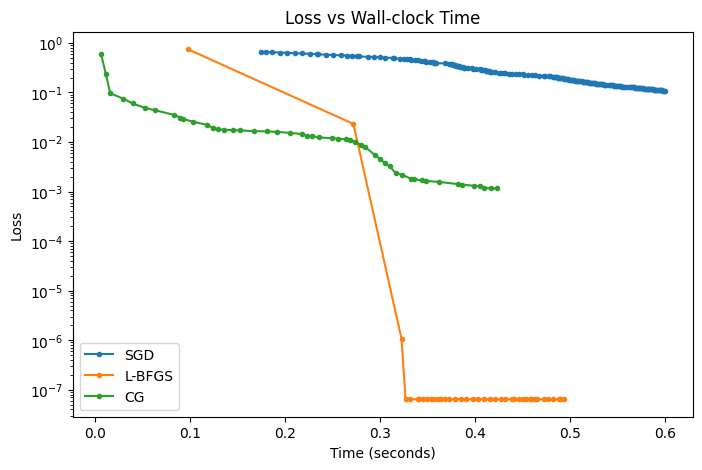

In [17]:
plt.figure(figsize=(8,5))
plt.plot(times_sgd, losses_sgd, label="SGD", marker='.')
plt.plot(times_lbfgs, losses_lbfgs, label="L-BFGS", marker='.')
plt.plot(times_cg, losses_cg, label="CG", marker='.')
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.title("Loss vs Wall-clock Time")
plt.show()


# Section 3

In [18]:
# Dataset: Fashion-MNIST (we can change to MNIST by datasets.MNIST)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_ds = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_ds  = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
print("\nTrain size:", len(train_ds))
print("Test size:", len(test_ds))
batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


100%|██████████| 26.4M/26.4M [00:01<00:00, 17.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 308kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.67MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.8MB/s]


Train size: 60000
Test size: 10000


In [19]:
# Model (3 hidden layers, 100 neurons each)
input_dim = 28*28
hidden = 100
num_classes = 10

class DeepNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x):
        return self.net(x)


model_sgd = DeepNet().to(device)
model_adam = DeepNet().to(device)
# Copying weights for fairness
model_adam.load_state_dict(model_sgd.state_dict())

<All keys matched successfully>

In [20]:
#@title Newtons method analysis
print("### Newtons Method Analysis ###")
def count_params(model):
    return sum(p.numel() for p in model.parameters())

N = count_params(model_sgd)
print("Total parameters N =", N)

N2 = N * N
bytes_needed = N2 * 4
GiB_needed = bytes_needed / (1024**3)
GB_needed = bytes_needed / 1e9
print(f"Hessian elements: {N2:,}")
print(f"Memory for full Hessian: {bytes_needed:,} bytes = {GiB_needed:.2f} GiB ≈ {GB_needed:.2f} GB")
print("Note: symmetric half-storage halves this, but still large.")

### Newtons Method Analysis ###
Total parameters N = 99710
Hessian elements: 9,942,084,100
Memory for full Hessian: 39,768,336,400 bytes = 37.04 GiB ≈ 39.77 GB
Note: symmetric half-storage halves this, but still large.


In [21]:
criterion = nn.CrossEntropyLoss()

lr_sgd = 0.01
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=lr_sgd)

lr_adam = 0.001
optimizer_adam = optim.Adam(model_adam.parameters(), lr=lr_adam)

def train_one_epoch(model, optimizer, loader, device, record_every=20, max_batches=None):
    model.train()
    times = []
    losses = []
    t0 = time.time()
    batch_count = 0
    for xb, yb in loader:
        xb = xb.to(device); yb = yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        batch_count += 1
        if batch_count % record_every == 0:
            times.append(time.time() - t0)
            losses.append(loss.item())
        if max_batches is not None and batch_count >= max_batches:
            break
    return times, losses

epochs = 4
record_every = 50  # log every 50 mini-batches

sgd_times_all, sgd_losses_all = [], []
adam_times_all, adam_losses_all = [], []

print("Starting training ...")
for e in range(epochs):
    print(f"Epoch {e+1}/{epochs} (SGD)")
    t_s, l_s = train_one_epoch(model_sgd, optimizer_sgd, train_loader, device, record_every=record_every, max_batches=1000)
    # append but offset times so they are cumulative across epochs
    if sgd_times_all:
        offset = sgd_times_all[-1]
    else:
        offset = 0.0
    sgd_times_all += [offset + tt for tt in t_s]
    sgd_losses_all += l_s

    print(f"Epoch {e+1}/{epochs} (Adam)")
    t_a, l_a = train_one_epoch(model_adam, optimizer_adam, train_loader, device, record_every=record_every, max_batches=1000)
    if adam_times_all:
        offset = adam_times_all[-1]
    else:
        offset = 0.0
    adam_times_all += [offset + tt for tt in t_a]
    adam_losses_all += l_a

print("Training done.")

Starting training ...
Epoch 1/4 (SGD)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/4 (Adam)
Epoch 2/4 (SGD)
Epoch 2/4 (Adam)
Epoch 3/4 (SGD)
Epoch 3/4 (Adam)
Epoch 4/4 (SGD)
Epoch 4/4 (Adam)
Training done.


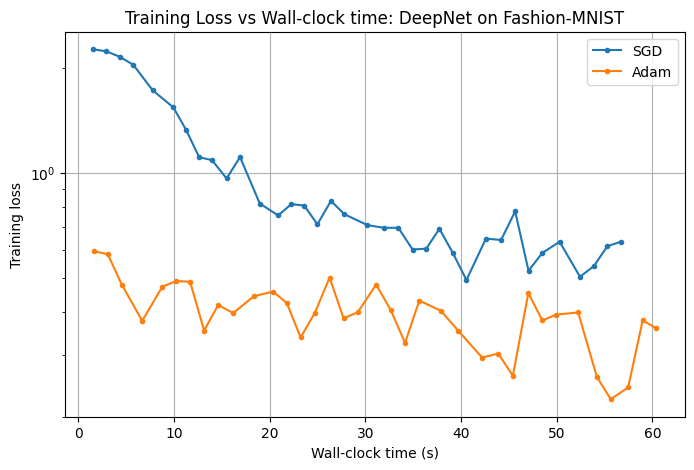

In [22]:
plt.figure(figsize=(8,5))
plt.plot(sgd_times_all, sgd_losses_all, label='SGD', marker='.')
plt.plot(adam_times_all, adam_losses_all, label='Adam',  marker='.')
plt.xlabel("Wall-clock time (s)")
plt.ylabel("Training loss")
plt.yscale('log')
plt.legend()
plt.title("Training Loss vs Wall-clock time: DeepNet on Fashion-MNIST")
plt.grid(True)
plt.show()

# Section 4

In [50]:
#@title Dataset

n_samples = 2000
n_features = 10

base = np.random.randn(n_samples, 1)
X = np.zeros((n_samples, n_features))

X[:, 0] = base[:, 0]
for j in range(1, n_features):
    # Highly correlated features
    if j%2==0:
      X[:, j] = 0.8 * base[:, 0] + 0.2 * np.random.randn(n_samples)
    else:
      X[:, j] = -0.6 * base[:, 0] + 0.2 * np.random.randn(n_samples)

X -= X.mean(axis=0)

# Quadratic + linear terms
true_w1 = np.linspace(1.0, 0.3, n_features)
true_w2 = np.linspace(0.5, -0.2, n_features)

linear_term = X @ true_w1
quad_term   = (X ** 2) @ true_w2

y = linear_term + 0.7 * quad_term + 0.3 * np.random.randn(n_samples)

split = int(0.8 * n_samples)
X_train = X[:split]
y_train = y[:split]
X_test  = X[split:]
y_test  = y[split:]


Condition number of Cov(X) = 678.0130182609772


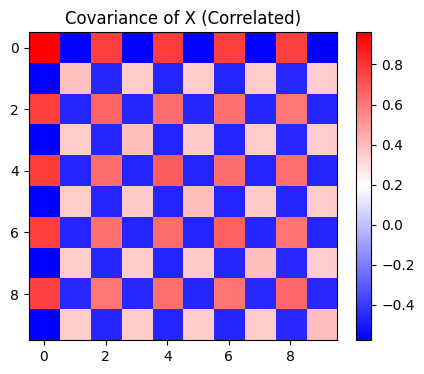

In [51]:
# Before QR
cov_X = np.cov(X_train, rowvar=False)
eigvals_X = np.linalg.eigvalsh(cov_X)
cond_X = eigvals_X.max() / eigvals_X.min()

print("Condition number of Cov(X) =", cond_X)

plt.figure(figsize=(5,4))
plt.title("Covariance of X (Correlated)")
plt.imshow(cov_X, cmap='bwr')
plt.colorbar()
plt.show()

Condition number of Cov(Q) = 1.0018074320188883


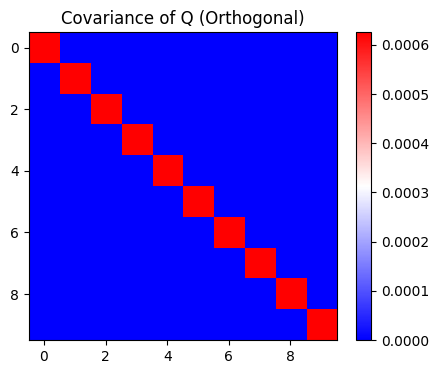

In [52]:
# After QR
Q, R = np.linalg.qr(X_train, mode='reduced')

cov_Q = np.cov(Q, rowvar=False)
eigvals_Q = np.linalg.eigvalsh(cov_Q)
cond_Q = eigvals_Q.max() / eigvals_Q.min()

print("Condition number of Cov(Q) =", cond_Q)

plt.figure(figsize=(5,4))
plt.title("Covariance of Q (Orthogonal)")
plt.imshow(cov_Q, cmap='bwr')
plt.colorbar()
plt.show()

In [53]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test.reshape(-1,1), dtype=torch.float32)

# Transform test set into Q-basis: X = Q R to Q = X R⁻¹
R_inv = np.linalg.pinv(R)
Q_train = Q
Q_test  = X_test @ R_inv.T

Q_train_t = torch.tensor(Q_train, dtype=torch.float32)
Q_test_t  = torch.tensor(Q_test, dtype=torch.float32)

class LinReg(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.linear = nn.Linear(n_in, 1)
    def forward(self, x):
        return self.linear(x)


model_X = LinReg(n_features)
model_Q = LinReg(n_features)
# Copy weights for fairness
model_Q.load_state_dict(model_X.state_dict())

loss_fn = nn.MSELoss()
lr = 0.05
opt_X = optim.SGD(model_X.parameters(), lr=lr)
opt_Q = optim.SGD(model_Q.parameters(), lr=lr)

In [54]:
epochs = 50
batch_size = 64

from torch.utils.data import DataLoader, TensorDataset
loader_X = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
loader_Q = DataLoader(TensorDataset(Q_train_t, y_train_t), batch_size=batch_size, shuffle=True)

losses_X = []
losses_Q = []
times_X = []
times_Q = []

In [55]:
# Train on X
start = time.time()
for epoch in range(epochs):
    for xb, yb in loader_X:
        opt_X.zero_grad()
        loss = loss_fn(model_X(xb), yb)
        loss.backward()
        opt_X.step()
    times_X.append(time.time() - start)
    losses_X.append(loss_fn(model_X(X_train_t), y_train_t).item())

In [56]:
# Train on Q
start = time.time()
for epoch in range(epochs):
    for xb, yb in loader_Q:
        opt_Q.zero_grad()
        loss = loss_fn(model_Q(xb), yb)
        loss.backward()
        opt_Q.step()
    times_Q.append(time.time() - start)
    losses_Q.append(loss_fn(model_Q(Q_train_t), y_train_t).item())


In [57]:
# evaluation
with torch.no_grad():
    test_mse_X = loss_fn(model_X(X_test_t), y_test_t).item()
    test_mse_Q = loss_fn(model_Q(Q_test_t), y_test_t).item()

print("Final Train Loss (X) =", losses_X[-1])
print("Final Train Loss (Q) =", losses_Q[-1])
print("Test MSE (X) =", test_mse_X)
print("Test MSE (Q) =", test_mse_Q)

Final Train Loss (X) = 0.9089544415473938
Final Train Loss (Q) = 2.116044044494629
Test MSE (X) = 1.3118202686309814
Test MSE (Q) = 2.1768527030944824


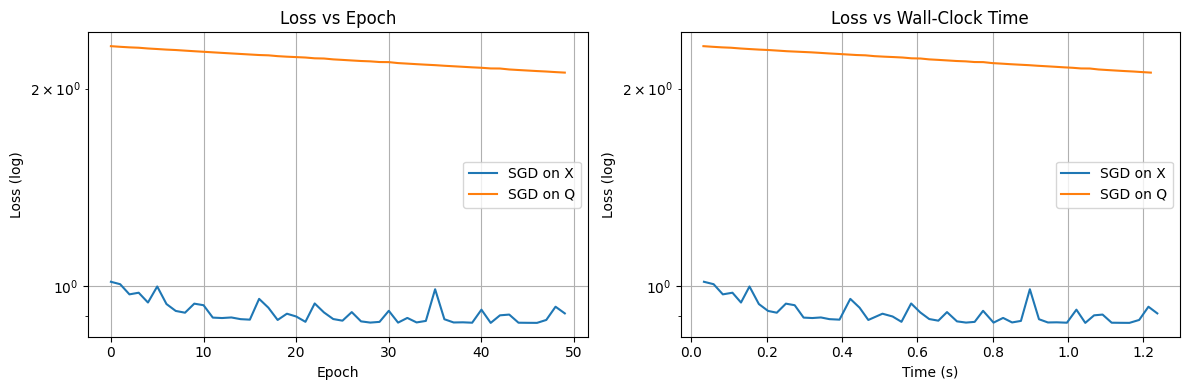

In [58]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(losses_X, label="SGD on X")
plt.plot(losses_Q, label="SGD on Q")
plt.yscale('log')
plt.xlabel("Epoch"); plt.ylabel("Loss (log)")
plt.title("Loss vs Epoch")
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(times_X, losses_X, label="SGD on X")
plt.plot(times_Q, losses_Q, label="SGD on Q")
plt.yscale('log')
plt.xlabel("Time (s)"); plt.ylabel("Loss (log)")
plt.title("Loss vs Wall-Clock Time")
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()